<a href="https://colab.research.google.com/github/ngoax/MathAgent/blob/main/Tool_calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sometimes colab throws an error for UTF-8, please then execute this code snippet and try again

In [ ]:
import locale
def getpreferredencoding():
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

Install dependencies

In [14]:
!pip install langchain
!pip install --upgrade --quiet numexpr
!pip install -qU langchain-google-genai
!pip install -qU langchain-docling
!pip install docling
!pip install langgraph
!pip install --upgrade --quiet  langchain-huggingface text-generation transformers google-search-results numexpr langchainhub sentencepiece jinja2 bitsandbytes accelerate

Set up Langsmith to be able to inspect agent later on ([generate access token](https://smith.langchain.com/))

In [15]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

set up gemini ([you need to generate an api](https://ai.google.dev/gemini-api/docs/api-key))

In [16]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key: ··········


Initialize model

In [27]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

Set up math tool

In [18]:
import math
import numexpr

def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )


Set up pdf reader

In [19]:
from langchain_docling import DoclingLoader

def pdfReader(filepath: str) -> str:
  """ get file content using docling

  Args:
      filepath (str): path to file

  Returns:
      str: file content
  """
  loader = DoclingLoader(file_path=filepath)
  docs = loader.load()
  #print(docs)
  return docs[0].page_content

  #return docs

  # for d in docs[:3]:
  #     print(f"- {d.page_content=}")

Set up tool use

In [28]:
tools = [calculator, pdfReader]
model_with_tools = model.bind_tools(tools)

Send a message to test wether tool calling is set up correctly (note: this doesn't call a tool but just indicates that the model would like to use the tool)

In [22]:
from langchain_core.messages import HumanMessage

response = model_with_tools.invoke([HumanMessage(content="/content/agenttest.pdf")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

ContentString: 
ToolCalls: [{'name': 'pdfReader', 'args': {'filepath': '/content/agenttest.pdf'}, 'id': 'a4ccf6b8-0426-4c38-9e8a-4ca6a2c76a23', 'type': 'tool_call'}]


Enable tool call by chaining ([credit](https://python.langchain.com/docs/versions/migrating_chains/llm_math_chain/))

In [23]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_node import ToolNode

class ChainState(TypedDict):
    """LangGraph state."""

    messages: Annotated[Sequence[BaseMessage], add_messages]


async def acall_chain(state: ChainState, config: RunnableConfig):
    last_message = state["messages"][-1]
    response = await model_with_tools.ainvoke(state["messages"], config)
     # Check if a tool was called
    if response.tool_calls:
        # If yes, return the response, continuing the chain
        return {"messages": [response]}
    else:
        # If not, signal the end of the chain
        return END

async def acall_model(state: ChainState, config: RunnableConfig):
    response = await model.ainvoke(state["messages"], config)
    return {"messages": [response]}


graph_builder = StateGraph(ChainState)
graph_builder.add_node("call_tool", acall_chain)
graph_builder.add_node("execute_tool", ToolNode(tools))
graph_builder.add_node("call_model", acall_model)
graph_builder.set_entry_point("call_tool")
graph_builder.add_edge("call_tool", "execute_tool")
graph_builder.add_edge("execute_tool", "call_model")
graph_builder.add_edge("call_model", "call_tool")
graph_builder.add_edge("call_model", END)
chain = graph_builder.compile()

Visualise graph

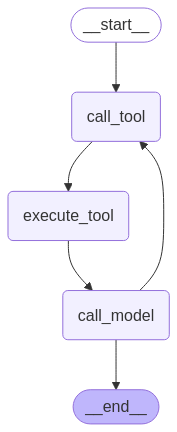

In [24]:
from IPython.display import Image

Image(chain.get_graph().draw_mermaid_png())

Example query

In [29]:
example_query = "was ist das ergebnis für die aufgabe in der folgenden datei: /content/agenttest.pdf"
#example_query = "whats 5+5"
events = chain.astream(
    {"messages": [("user", example_query)]},
    stream_mode="values",
)

async for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

was ist das ergebnis für die aufgabe in der folgenden datei: /content/agenttest.pdf
================================== Ai Message ==================================
Tool Calls:
  pdfReader (f5414b1e-d73e-4c0b-a100-8980f36fa48c)
 Call ID: f5414b1e-d73e-4c0b-a100-8980f36fa48c
  Args:
    filepath: /content/agenttest.pdf
================================= Tool Message =================================
Name: pdfReader

whats 5+5?
================================== Ai Message ==================================

Die Aufgabe in der PDF-Datei lautet "Was ist 5 + 5?".  Das Ergebnis ist 10.
================================== Ai Message ==================================
Tool Calls:
  calculator (127068b2-3221-4026-87ce-6a7ad4e25b81)
 Call ID: 127068b2-3221-4026-87ce-6a7ad4e25b81
  Args:
    expression: 5 + 5
================================= Tool Message =================================
Name: calculator

10
=======

}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 10
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 8
}
]